# Assignment 2 - Question 1


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

In [37]:
np.random.seed(2)

## Data Creation Part


<img src="/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 02/Images/1.png">


In [38]:
priors = np.array([0.6, 0.4])
means = np.array([[[-0.9, -1.1], [0.8, 0.75]], [[-1.1, 0.9], [0.9, -0.75]]])
cov = np.array([[0.75, 0], [0, 1.25]])
weight = 0.5


def generate_data(n_components, priors, means, cov):
    n_components_counts = (n_components * np.array(priors)).astype(int)

    def generate_samples(label, mean_idx):
        return np.random.multivariate_normal(
            means[label][mean_idx], cov, n_components_counts[label] // 2
        )

    samples_0 = np.vstack([generate_samples(0, 0), generate_samples(0, 1)])
    samples_1 = np.vstack([generate_samples(1, 0), generate_samples(1, 1)])

    samples = np.vstack([samples_0, samples_1])
    labels = np.hstack(
        [np.zeros(n_components_counts[0]), np.ones(n_components_counts[1])]
    )

    means_out = {
        f"{label}{idx+1}": np.mean(generate_samples(label, idx), axis=0)
        for label in [0, 1]
        for idx in [0, 1]
    }

    covs_out = {
        f"{label}{idx+1}": np.cov(generate_samples(label, idx), rowvar=False)
        for label in [0, 1]
        for idx in [0, 1]
    }

    return samples, labels, means_out, covs_out

In [39]:
D_20, L_20, M_20, C_20 = generate_data(20, priors, means, cov)
D_200, L_200, M_200, C_200 = generate_data(200, priors, means, cov)
D_2000, L_2000, M_2000, C_2000 = generate_data(2000, priors, means, cov)
D_10K_test, L_10K_test, M_10K_test, C_10K_test = generate_data(
    10000, priors, means, cov
)

means_data = {"D_20": M_20, "D_200": M_200, "D_2000": M_2000, "D_10K_test": M_10K_test}
covs_data = {"D_20": C_20, "D_200": C_200, "D_2000": C_2000, "D_10K_test": C_10K_test}

## Part 1


<img src="/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 02/Images/1_1.png">


<h4>Theoretical Optimal Classifier</h4>

$$ P(L=0) = 0.6 $$
$$ P(L=1) = 0.4 $$
$$ \frac{P(X|L=0)}{P(X|L=1)} \stackrel{?}{=} \frac{(\lambda_{01} - \lambda_{11})P(L=0)}{(\lambda_{10} - \lambda_{00})P(L=1)} $$

Using 0-1 Loss Matrix:  
$$ \frac{P(X|L=0)}{P(X|L=1)} \stackrel{?}{=} \frac{P(L=0)}{P(L=1)} $$

Next, for the Gaussian functions:

$$ \frac{0.5 \cdot g(x|m_{01}, C_{01}) + 0.5 \cdot g(x|m_{02}, C_{02})}{0.5 \cdot g(x|m_{11}, C_{11}) + 0.5 \cdot g(x|m_{12}, C_{12})} \stackrel{?}{=} \frac{0.6}{0.4} $$

Finally:
$$ \frac{0.5 \cdot g(x|m_{01}, C_{01}) + 0.5 \cdot g(x|m_{02}, C_{02})}{0.5 \cdot g(x|m_{11}, C_{11}) + 0.5 \cdot g(x|m_{12}, C_{12})} \stackrel{?}{=} 1.5 $$


In [40]:
def get_px_given_label(label, name, samples, means, cov, weight):
    return weight * (
        multivariate_normal.pdf(
            samples, means[name][f"{label}1"], cov[name][f"{label}1"]
        )
        + multivariate_normal.pdf(
            samples, means[name][f"{label}2"], cov[name][f"{label}2"]
        )
    )

In [41]:
def apply_map(name, means, cov, priors, X):
    potential_labels = [0, 1]
    pl = len(potential_labels)
    rows = X.shape[0]
    pxgivenl = np.zeros((pl, rows))

    for cls in potential_labels:
        pxgivenl[cls, :] = get_px_given_label(cls, name, X, means, cov, weight)

    px = priors @ pxgivenl
    classPosteriors = (priors[:, np.newaxis] * pxgivenl) / px

    lossMatrix_0_1 = np.ones((pl, pl)) - np.eye(pl)
    expectedRisks = lossMatrix_0_1 @ classPosteriors
    decisions = np.argmin(expectedRisks, axis=0)

    return decisions


# def apply_map(name, means, cov, priors, X):
#     pl = len(priors)
#     pxgivenl = np.array(
#         [get_px_given_label(cls, name, X, means, cov, 0.5) for cls in range(pl)]
#     )
#     px = priors @ pxgivenl
#     classPosteriors = (priors[:, np.newaxis] * pxgivenl) / px
#     expectedRisks = (np.ones((pl, pl)) - np.eye(pl)) @ classPosteriors
#     decisions = np.argmin(expectedRisks, axis=0)

#     return decisions

In [42]:
def predict_map_model(name, means, cov, X):
    pxgivenl = np.array(
        [get_px_given_label(cls, name, X, means, cov, weight) for cls in [0, 1]]
    )
    px = priors @ pxgivenl
    classPosteriors = (priors[:, np.newaxis] * pxgivenl) / px
    lossMatrix_0_1 = np.ones((2, 2)) - np.eye(2)
    expectedRisks = lossMatrix_0_1 @ classPosteriors
    decisions = np.argmin(expectedRisks, axis=0)

    return decisions, classPosteriors[1, :]

In [43]:
decisions_D20, decisions_D200, decisions_D2000 = [
    apply_map(name, means_data, covs_data, priors, X)
    for name, X in [("D_20", D_20), ("D_200", D_200), ("D_2000", D_2000)]
]

In [44]:
fprs, tprs, errors, dout = [], [], [], []
for name in ["D_20", "D_200", "D_2000"]:
    decisions, posteriors = predict_map_model(name, means_data, covs_data, D_10K_test)
    fpr, tpr, thresholds = roc_curve(L_10K_test, posteriors)
    fprs.append(fpr)
    tprs.append(tpr)
    errors.append(0.4 * (1 - tpr) + 0.6 * fpr)
    dout.append(decisions)

In [45]:
def min_error_analysis(fpr, tpr, error):
    idx_min_error = np.argmin(error)
    return fpr[idx_min_error], tpr[idx_min_error], error[idx_min_error]


min_errors = [
    min_error_analysis(fpr, tpr, error) for fpr, tpr, error in zip(fprs, tprs, errors)
]

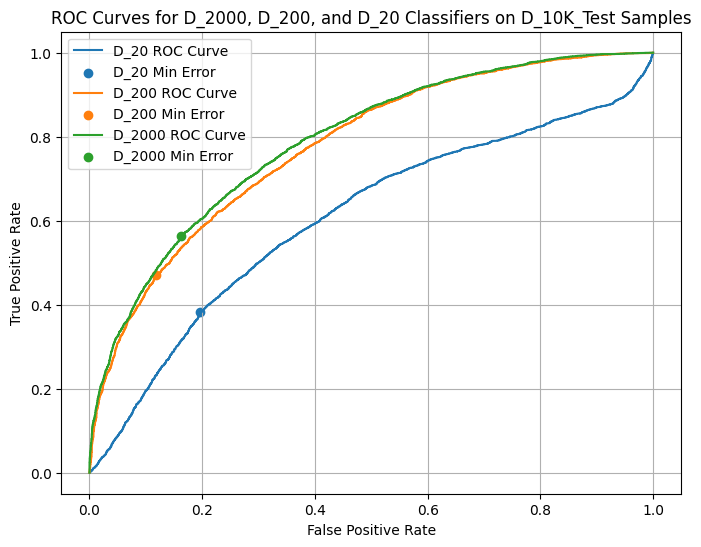

In [46]:
plt.figure(figsize=(8, 6))
for i, label in enumerate(["D_20", "D_200", "D_2000"]):
    plt.plot(fprs[i], tprs[i], label=f"{label} ROC Curve")
    plt.scatter(*min_errors[i][:2], label=f"{label} Min Error")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for D_2000, D_200, and D_20 Classifiers on D_10K_Test Samples")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
print("PErrors on 10k Test Set based on the classifiers, min being at D_2000")
print(f"Estimated min-P(error) for D_20 classifier: {min_errors[0][2]:.4f}")
print(f"Estimated min-P(error) for D_200 classifier: {min_errors[1][2]:.4f}")
print(f"Estimated min-P(error) for D_2000 classifier: {min_errors[2][2]:.4f}")

PErrors on 10k Test Set based on the classifiers, min being at D_2000
Estimated min-P(error) for D_20 classifier: 0.3655
Estimated min-P(error) for D_200 classifier: 0.2826
Estimated min-P(error) for D_2000 classifier: 0.2721


The ROC curves and minimum error points show that the classifier's performance improves as the training set size increases. The classifier trained on D_2000 achieves the lowest error rate, which is our best estimate of the min-P(error) achievable by the theoretical optimal classifier. This performance is expected as the larger dataset allows for better estimation of the true underlying distribution.


### Optional Part


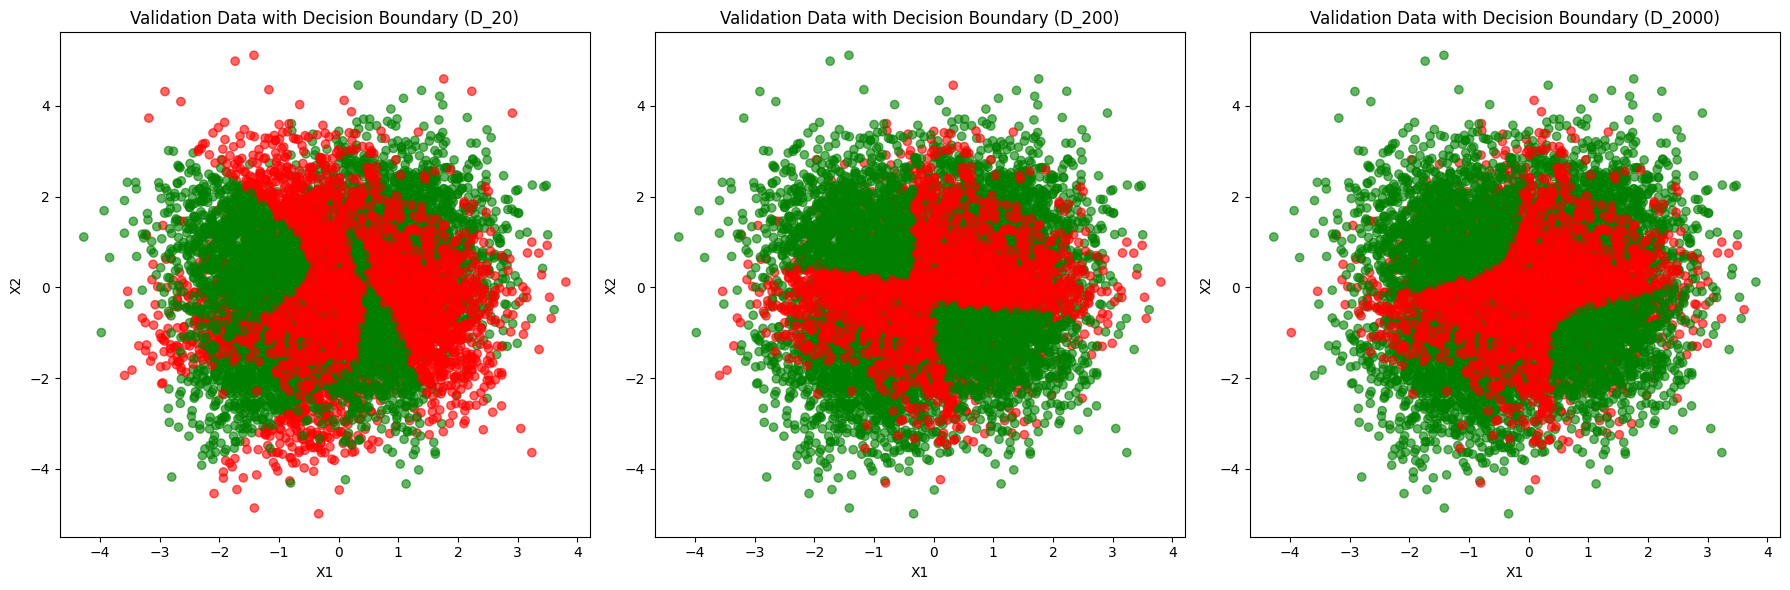

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

colors_1 = np.where(dout[0] == L_10K_test, "green", "red")
axs[0].scatter(D_10K_test[:, 0], D_10K_test[:, 1], c=colors_1, alpha=0.6)
axs[0].set_title("Validation Data with Decision Boundary (D_20)")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")

colors_2 = np.where(dout[1] == L_10K_test, "green", "red")
axs[1].scatter(D_10K_test[:, 0], D_10K_test[:, 1], c=colors_2, alpha=0.6)
axs[1].set_title("Validation Data with Decision Boundary (D_200)")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X2")

colors_3 = np.where(dout[2] == L_10K_test, "green", "red")
axs[2].scatter(D_10K_test[:, 0], D_10K_test[:, 1], c=colors_3, alpha=0.6)
axs[2].set_title("Validation Data with Decision Boundary (D_2000)")
axs[2].set_xlabel("X1")
axs[2].set_ylabel("X2")

plt.tight_layout()
plt.show()

## Part 2 (including optional)


<img src="/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 02/Images/1_2.png">


Linear Logistic Function

$$ h(x, w) = \frac{1}{1+e^{-w^Tz(x)}}$$
$$ z(x) = [1 \space X^T]^T$$
$$\begin{bmatrix} 1 & X^T \end{bmatrix}^T$$
$$ P(L = 1 | x, w) = h_w(x) \space and \space P(L = 0 | x, w) = 1 - h_w(x) $$
$$ P(L|x,w) = (h_w(x))^L (1-h_w(x))^{1-L} $$
given we have data with n iid samples,
$$ \hat{w}_{ML} = \argmax_w P(L|x, w) $$
$$ \hat{w}_{ML} = \argmax_w \prod_{i=1}^{n} P(L|x, w) $$
$$ \hat{w}_{ML} = \argmax_{w} \prod_{i=1}^{n} (h_w(x))^{L_{i}} (1-h_w(x))^{1-L_{i}} $$
taking log on both the sides,
$$ \hat{w}_{ML} = \argmax_{w} \prod_{i=1}^{n} log ((h_w(x))^{L_{i}} (1-h_w(x))^{1-L_{i}}) $$
$$ \hat{w}_{ML} = \argmax_{w} \sum_{i=1}^{n} L_i log ((h_w(x)) + ({1-L_{i}})(1-h_w(x))) $$
converting into a minimization problem, 
$$ \hat{w}_{ML} = \argmin_{w} \frac{-1}{N} \sum_{i=1}^{n} L_i log ((h_w(x)) + ({1-L_{i}})(1-h_w(x))) $$
$$ \hat{w}_{ML} = \argmin_{w} \frac{-1}{N} \sum_{i=1}^{N} \left[ L_i \log\left(h_w(x_i)\right) + (1-L_i) \log\left(1-h_w(x_i)\right) \right] $$


In [50]:
def get_confusion_matrix(labels, decisions, n):
    confusion_matrix = np.zeros((n, n), dtype=int)
    for true, pred in zip(labels, decisions):
        true = int(true)
        pred = int(pred)
        confusion_matrix[pred, true] += 1
    return confusion_matrix


def get_perror(confusion_matrix):
    total_predictions = confusion_matrix.sum()
    correct_classifications = confusion_matrix.diagonal().sum()
    misclassifications = total_predictions - correct_classifications
    perror = misclassifications / total_predictions
    return perror


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def cost_function(w, X, n, y):
    h = sigmoid(np.dot(X, w)) 
    cost = (-1 / n) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost


def optimize_weights(X, y, case):
    n = X.shape[0]
    if case == "L":
        X_train = np.hstack([np.ones((X.shape[0], 1)), X])
        initial_w = np.zeros(X_train.shape[1])
    elif case == "Q":
        X_train = np.hstack([
            np.ones((X.shape[0], 1)),
            X[:, 0].reshape(-1, 1), 
            X[:, 1].reshape(-1, 1),   
            (X[:, 0]**2).reshape(-1, 1), 
            (X[:, 0] * X[:, 1]).reshape(-1, 1),
            (X[:, 1]**2).reshape(-1, 1)
        ])
        initial_w = np.zeros(X_train.shape[1])
        initial_w = np.zeros(X_train.shape[1])
    result = minimize(cost_function, initial_w, args=(X_train, n, y), method="Nelder-Mead")
    return result.x


def predict(new_data, optimized_weights, case):
    if case == "L":
        new_data_with_bias = np.hstack([np.ones((new_data.shape[0], 1)), new_data])
    if case == "Q":
        new_data_with_bias = np.hstack([
            np.ones((new_data.shape[0], 1)),
            new_data[:, 0].reshape(-1, 1), 
            new_data[:, 1].reshape(-1, 1),   
            (new_data[:, 0]**2).reshape(-1, 1), 
            (new_data[:, 0] * new_data[:, 1]).reshape(-1, 1),
            (new_data[:, 1]**2).reshape(-1, 1)
        ])
    probabilities = sigmoid(np.dot(new_data_with_bias, optimized_weights))
    predictions = (probabilities >= 0.5).astype(int)
    return predictions, probabilities


result_20_L = optimize_weights(D_20, L_20, "L")
result_200_L = optimize_weights(D_200, L_200, "L")
result_2000_L = optimize_weights(D_2000, L_2000, "L")
result_20_Q = optimize_weights(D_20, L_20, "Q")
result_200_Q = optimize_weights(D_200, L_200, "Q")
result_2000_Q = optimize_weights(D_2000, L_2000, "Q")

decisions_D20_L, prob_D20_L = predict(D_10K_test, result_20_L, "L")
decisions_D200_L, prob_D200_L = predict(D_10K_test, result_200_L, "L")
decisions_D2000_L, prob_D2000_L = predict(D_10K_test, result_2000_L, "L")
decisions_D20_Q, prob_D20_Q = predict(D_10K_test, result_20_Q, "Q")
decisions_D200_Q, prob_D200_Q = predict(D_10K_test, result_200_Q, "Q")
decisions_D2000_Q, prob_D2000_Q = predict(D_10K_test, result_2000_Q, "Q")

mat_20_L = get_confusion_matrix(decisions_D20_L, L_10K_test, 2)
mat_200_L = get_confusion_matrix(decisions_D200_L, L_10K_test, 2)
mat_2000_L = get_confusion_matrix(decisions_D2000_L, L_10K_test, 2)
mat_20_Q = get_confusion_matrix(decisions_D20_Q, L_10K_test, 2)
mat_200_Q = get_confusion_matrix(decisions_D200_Q, L_10K_test, 2)
mat_2000_Q = get_confusion_matrix(decisions_D2000_Q, L_10K_test, 2)

p_20_L = get_perror(mat_20_L)
p_200_L = get_perror(mat_200_L)
p_2000_L = get_perror(mat_2000_L)
p_20_Q = get_perror(mat_20_Q)
p_200_Q = get_perror(mat_200_Q)
p_2000_Q = get_perror(mat_2000_Q)

In [51]:
print(f"The bias and weights for the D_20: {result_20_L}")
print(f"The bias and weights for the D_200: {result_200_L}")
print(f"The bias and weights for the D_2000: {result_2000_L}")
print(f"The bias and weights for the D_20, Quadratic case: {result_20_Q}")
print(f"The bias and weights for the D_200, Quadratic case: {result_200_Q}")
print(f"The bias and weights for the D_2000, Quadratic case: {result_2000_Q}")

The bias and weights for the D_20: [-0.37342715  0.12084368  0.05388029]
The bias and weights for the D_200: [-0.42170258 -0.11907731  0.12325838]
The bias and weights for the D_2000: [-0.40971034 -0.02950639  0.12412103]
The bias and weights for the D_20, Quadratic case: [-0.48996073 -0.4110244  -0.39225219  0.41993891 -1.54556269 -0.42944944]
The bias and weights for the D_200, Quadratic case: [-0.52909416 -0.17118677 -0.01874403 -0.01207612 -0.78185205 -0.00981614]
The bias and weights for the D_2000, Quadratic case: [-0.52337666  0.01366269  0.0245992   0.12639664 -0.88698787 -0.05012994]


In [52]:
print("Confusion Matrix D_20 Linear")
mat_20_L

Confusion Matrix D_20 Linear


array([[5924,   76],
       [3985,   15]])

In [53]:
print("Confusion Matrix D_200 Linear")
mat_200_L

Confusion Matrix D_200 Linear


array([[5978,   22],
       [3702,  298]])

In [54]:
print("Confusion Matrix D_2000 Linear")
mat_2000_L

Confusion Matrix D_2000 Linear


array([[5976,   24],
       [3942,   58]])

In [55]:
print("Confusion Matrix D_20 Quadratic")
mat_20_Q

Confusion Matrix D_20 Quadratic


array([[4897, 1103],
       [1761, 2239]])

In [56]:
print("Confusion Matrix D_200 Quadratic")
mat_200_Q

Confusion Matrix D_200 Quadratic


array([[5426,  574],
       [2270, 1730]])

In [57]:
print("Confusion Matrix D_2000 Quadratic")
mat_2000_Q

Confusion Matrix D_2000 Quadratic


array([[5250,  750],
       [2023, 1977]])

In [58]:
print(f"The perror for the D_20: {p_20_L}")
print(f"The perror for the D_200: {p_200_L}")
print(f"The perror for the D_2000: {p_2000_L}")
print(f"The perror for the D_20, Quadratic case:: {p_20_Q}")
print(f"The perror for the D_200, Quadratic case:: {p_200_Q}")
print(f"The perror for the D_2000, Quadratic case:: {p_2000_Q}")

The perror for the D_20: 0.4061
The perror for the D_200: 0.3724
The perror for the D_2000: 0.3966
The perror for the D_20, Quadratic case:: 0.2864
The perror for the D_200, Quadratic case:: 0.2844
The perror for the D_2000, Quadratic case:: 0.2773


In [81]:
def plot_decision_boundaries(datasets, labels, weights_list, titles, perrors, case):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs = axs.ravel()
    
    for i, (X, y, weights, title) in enumerate(zip(datasets, labels, weights_list, titles)):
        ax = axs[i]

        if case == "L":
            w0, w1, w2 = weights
            z = w0 + w1 * X[:, 0] + w2 * X[:, 1]

        else:  # case == "Q"
            w0, w1, w2, w3, w4, w5 = weights
            z = (w0 + w1 * X[:, 0] + w2 * X[:, 1] + 
                 w3 * X[:, 0]**2 + w4 * X[:, 1]**2 + w5 * X[:, 0] * X[:, 1])

        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x1_grid = np.linspace(x1_min, x1_max, 1000)

        if case == "L":
            X2_boundary = -(w0 + w1 * x1_grid) / w2
            ax.plot(x1_grid, X2_boundary, "k--", label="Decision Boundary", linewidth=2)
            
        else:
            X2_boundary_positive = (- (w5 * x1_grid) + 
                                    np.sqrt((w5 * x1_grid) ** 2 - 4 * w2 * (w0 + w1 * x1_grid + w3 * x1_grid ** 2))) / (2 * w2)
            
            X2_boundary_negative = (- (w5 * x1_grid) - 
                                    np.sqrt((w5 * x1_grid) ** 2 - 4 * w2 * (w0 + w1 * x1_grid + w3 * x1_grid ** 2))) / (2 * w2)

            ax.plot(x1_grid, X2_boundary_positive, "k--", label="Decision Boundary Positive Root", linewidth=2)
            ax.plot(x1_grid, X2_boundary_negative, "k--", label="Decision Boundary Negative Root", linewidth=2)


        y_pred = (z >= 0).astype(int)
        correct_mask = y_pred == y
        incorrect_mask = y_pred != y

        ax.scatter(
            X[correct_mask, 0], 
            X[correct_mask, 1],
            color="green",
            label="Correct",
            alpha=0.6,
            s=10
        )

        ax.scatter(
            X[incorrect_mask, 0], 
            X[incorrect_mask, 1],
            color="red",
            label="Incorrect",
            alpha=0.6,
            s=10
        )

        ax.set_title(f"{title}")

        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.legend(loc="upper left", fontsize="small")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

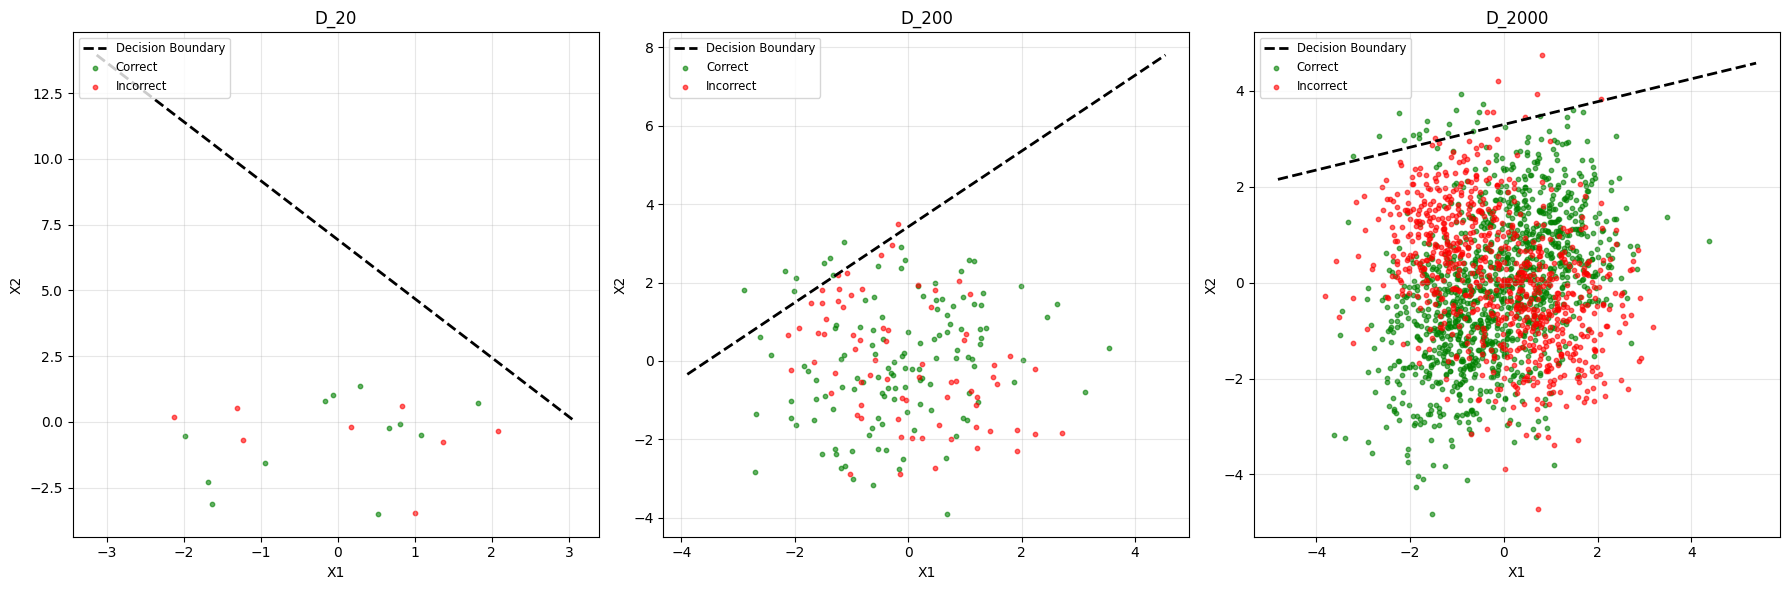

In [82]:
datasets = [D_20, D_200, D_2000]
labels = [L_20, L_200, L_2000]
weights_list = [result_20_L, result_200_L, result_2000_L]
titles = ["D_20", "D_200", "D_2000"]
perrors = [p_20_L, p_200_L, p_2000_L]
plot_decision_boundaries(datasets, labels, weights_list, titles, perrors, "L")

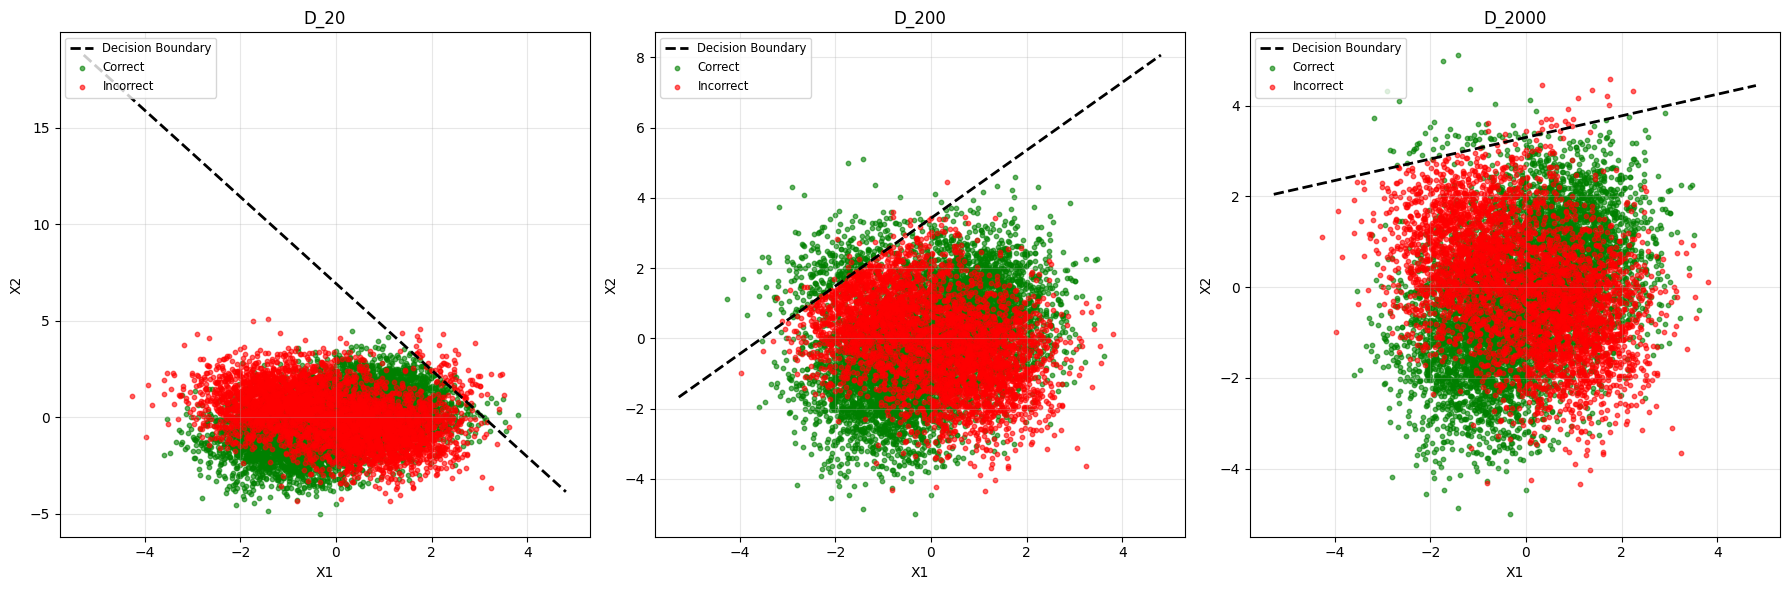

In [83]:
datasets = [D_10K_test] * 3
labels = [L_10K_test] * 3
weights_list = [result_20_L, result_200_L, result_2000_L]
titles = ["D_20", "D_200", "D_2000"]
perrors = [p_20_L, p_200_L, p_2000_L]
plot_decision_boundaries(datasets, labels, weights_list, titles, perrors, "L")

/var/folders/hh/njmxn3hn0qgb96zkxs4bc_pr0000gn/T/ipykernel_92674/268178775.py:26: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((w5 * x1_grid) ** 2 - 4 * w2 * (w0 + w1 * x1_grid + w3 * x1_grid ** 2))) / (2 * w2)
/var/folders/hh/njmxn3hn0qgb96zkxs4bc_pr0000gn/T/ipykernel_92674/268178775.py:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((w5 * x1_grid) ** 2 - 4 * w2 * (w0 + w1 * x1_grid + w3 * x1_grid ** 2))) / (2 * w2)


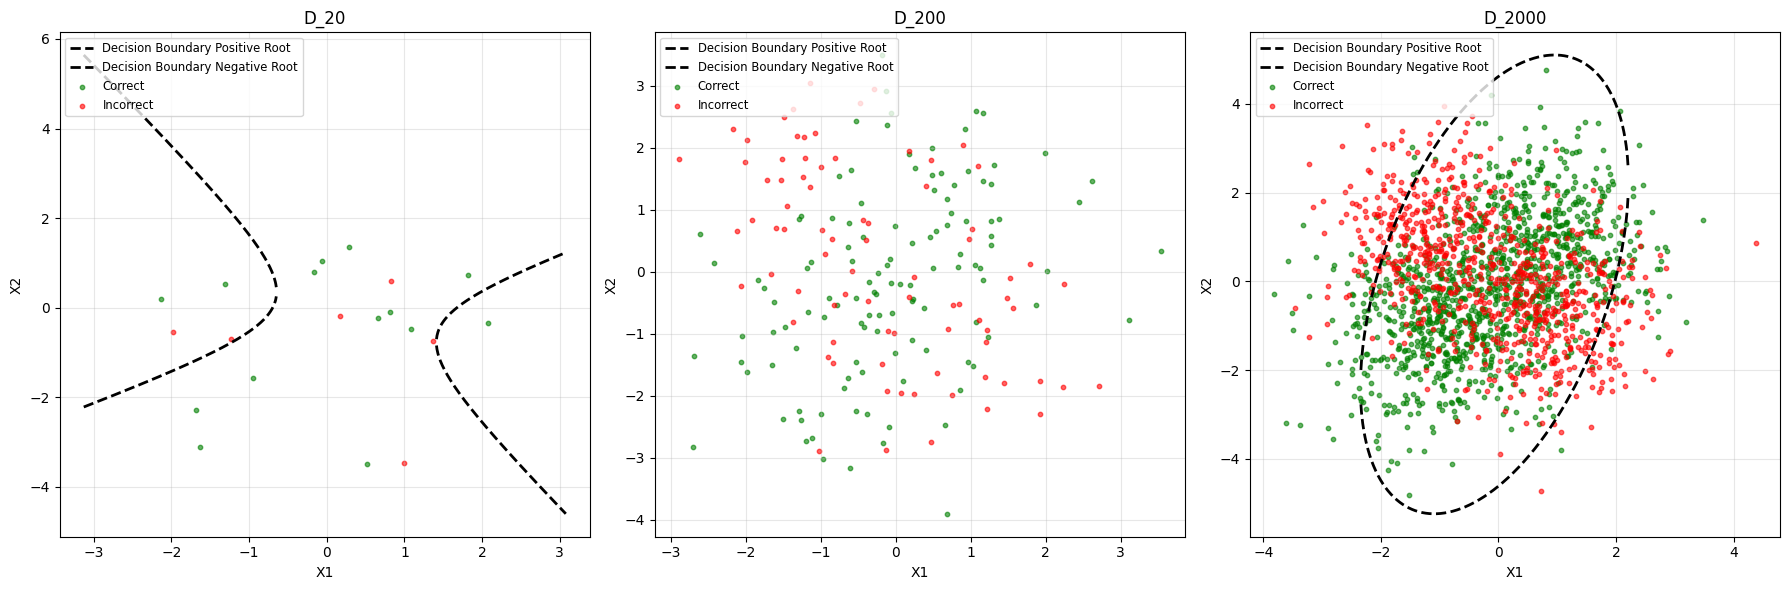

In [84]:
datasets = [D_20, D_200, D_2000]
labels = [L_20, L_200, L_2000]
weights_list = [result_20_Q, result_200_Q, result_2000_Q]
titles = ["D_20", "D_200", "D_2000"]
perrors = [p_20_Q, p_200_Q, p_2000_Q]
plot_decision_boundaries(datasets, labels, weights_list, titles, perrors, "Q")

/var/folders/hh/njmxn3hn0qgb96zkxs4bc_pr0000gn/T/ipykernel_92674/268178775.py:26: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((w5 * x1_grid) ** 2 - 4 * w2 * (w0 + w1 * x1_grid + w3 * x1_grid ** 2))) / (2 * w2)
/var/folders/hh/njmxn3hn0qgb96zkxs4bc_pr0000gn/T/ipykernel_92674/268178775.py:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((w5 * x1_grid) ** 2 - 4 * w2 * (w0 + w1 * x1_grid + w3 * x1_grid ** 2))) / (2 * w2)


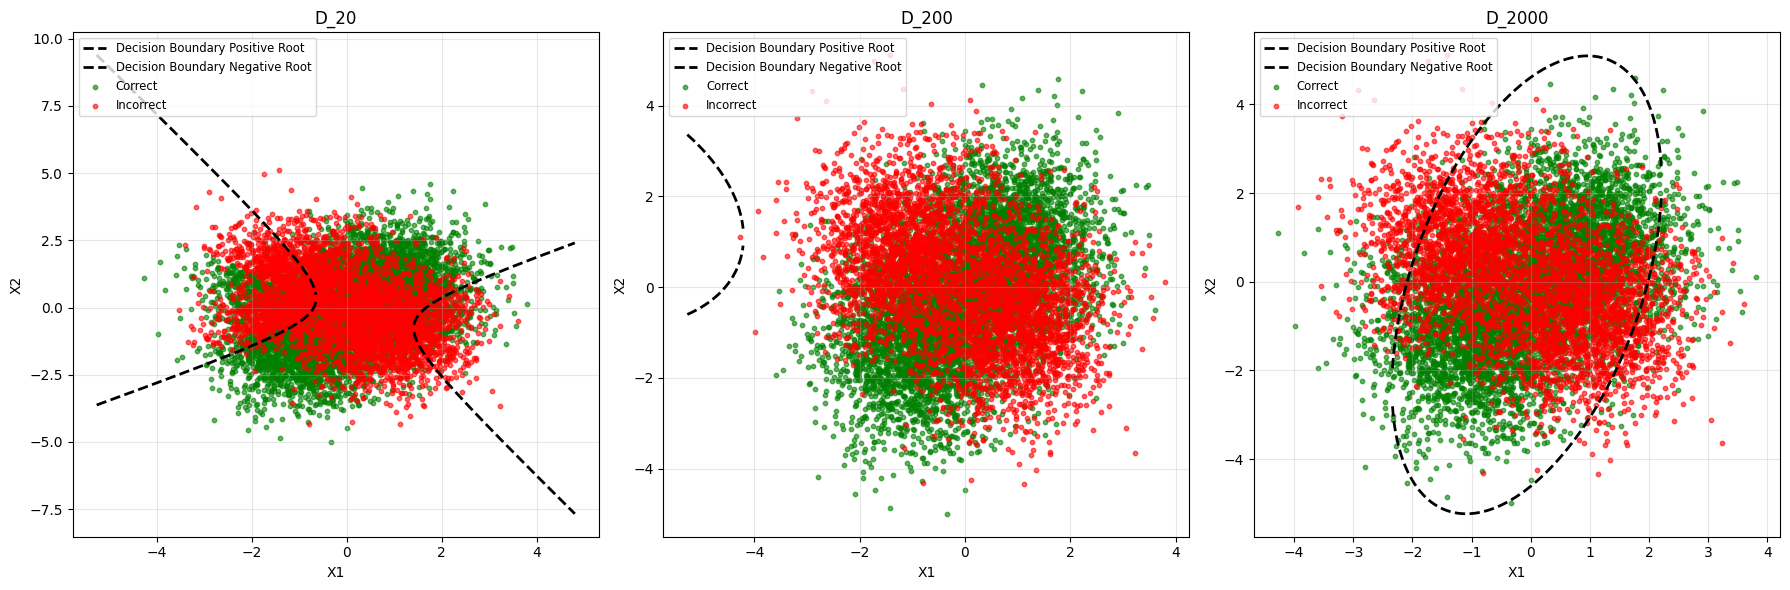

In [85]:
datasets = [D_10K_test] * 3
labels = [L_10K_test] * 3
weights_list = [result_20_Q, result_200_Q, result_2000_Q]
titles = ["D_20", "D_200", "D_2000"]
perrors = [p_20_Q, p_200_Q, p_2000_Q]
plot_decision_boundaries(datasets, labels, weights_list, titles, perrors, "Q")

## Part 3 - Discussion


<img src="/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 02/Images/1_D.png">

The theoretical optimal classifier, showed improving performance as the training set size increased. The estimated minimum probability of error (min-P(error)) for each dataset was:

- D_20 classifier: 0.3655
- D_200 classifier: 0.2826
- D_2000 classifier: 0.2721

The linear logistic regression model showed varying performance across different dataset sizes:

- D_20: P(error) = 0.4061
- D_200: P(error) = 0.3724
- D_2000: P(error) = 0.3966

The quadratic logistic regression model demonstrated superior performance compared to the linear model:

- D_20: P(error) = 0.2864
- D_200: P(error) = 0.2844
- D_2000: P(error) = 0.2773

Comparison of Models

The quadratic logistic regression model consistently outperformed the linear model across all dataset sizes. The decision boundary is non-linear. For the linear model, increasing the dataset size didn't always lead to better performance. However, the quadratic model showed an improvement as the dataset size increased. The quadratic logistic regression model achieved performance close to the theoretical optimal classifier, especially for the larger datasets.